# GRASP Forest & Rotation Forest for Imbalanced Classification - Comparative Study

**Objective:** Implement and compare state-of-the-art ensemble methods from literature with our Ensemble Undersampling approach

**Research Question:** Do ensemble methods from literature (GRASP Forest, Rotation Forest) improve Class 4 detection on the extremely imbalanced Scania dataset?

---

## Literature Review

### Paper 1: "GRASP Forest: A New Ensemble Method for Trees" (Diez-Pastor et al.)

**Key Innovation:**
- Uses GRASP (Greedy Randomized Adaptive Search Procedure) metaheuristic
- Adds controlled randomness at TWO levels:
  1. **Attribute selection**: Pick randomly from top candidates (not just best)
  2. **Split point selection**: Pick randomly from good split points

**How GRASP Works:**
- Creates **Restricted Candidate List (RCL)** of "good enough" options
- RCL formula: `Include if Gain ≥ α×MaxGain + (1-α)×MinGain`
- **α parameter** controls randomness:
  - α = 1.0: Greedy (deterministic, picks best)
  - α = 0.5: Moderate randomness
  - α = 0.0: Fully random

**Relevance to Our Problem:**
- Tested on imbalanced UCI datasets
- Decision tree ensemble (compatible with our approach)
- Can potentially combine with undersampling
- Addresses diversity (complementary to our data balancing)

---

### Paper 2: "Ensembles of Decision Trees for Imbalanced Data" (Rodríguez et al. 2011)

**Key Finding:**
- **Rotation Forest** ranked BEST among 14 ensemble methods
- Average rank: 9-13 (vs 48-49 for undersampling alone)
- Outperformed: Bagging, AdaBoost, SMOTE, Undersampling

**How Rotation Forest Works:**
- Randomly splits attributes into K groups
- For each group: selects random class subset, bootstrap samples, applies PCA
- Trains trees on rotated feature space (all PCA components)
- Diversity from feature space rotation, not data sampling

**Critical Detail:**
- Tested on UCI datasets with 4.77%-35% minority class (≈2:1 to 20:1 imbalance)
- Important conclusion: "Ensemble method much more important than tree type"
- CCPDT (imbalanced-specific tree) showed NO advantage over C4.5

**Relevance to Our Problem:**
- Current SOTA for imbalanced ensemble learning
- Scania dataset: 3.0% minority (27:1) - MORE EXTREME than UCI datasets
- Critical test: Does #1 literature method transfer to industrial data?

---

## Experimental Setup

**We will compare:**
1. **Baseline**: Ensemble Undersampling (from notebook 08)
2. **GRASP Forest**: Pure GRASP approach (various α values)
3. **Hybrid GRASP**: GRASP + Undersampling combined
4. **Rotation Forest**: Original implementation (best from Rodríguez et al.)

**Evaluation Focus:**
- **Primary metric**: Class 4 Recall (must catch imminent failures)
- **Secondary metric**: Class 4 Precision (minimize false alarms)
- **Analysis**: WHY performance differs (most important!)
- **Transferability**: Do methods optimized for UCI datasets (≤20:1) transfer to Scania (27:1)?

---
## 1. Setup & Load Previous Work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
%matplotlib inline

print("✅ Libraries imported")

✅ Libraries imported


### Load Preprocessed Data from Notebook 08

We'll reuse the same preprocessing, feature engineering, and feature selection pipeline

In [2]:
# NOTE: Run notebook 08 first to generate these variables!
# For now, we'll reload and recreate the data pipeline

print("📂 Loading raw data...")
train_ops = pd.read_csv('../data/raw/train_operational_readouts.csv')
val_ops = pd.read_csv('../data/raw/validation_operational_readouts.csv')
train_tte = pd.read_csv('../data/raw/train_tte.csv')
val_labels = pd.read_csv('../data/raw/validation_labels.csv')

print(f"✅ Data loaded:")
print(f"   Train: {train_ops.shape}")
print(f"   Val: {val_ops.shape}")

📂 Loading raw data...
✅ Data loaded:
   Train: (1122452, 107)
   Val: (196227, 107)


In [3]:
# Create multiclass labels (same as notebook 08)
print("🏷️ Creating multiclass labels...")

train_merged = train_ops.merge(train_tte[['vehicle_id', 'length_of_study_time_step', 'in_study_repair']], 
                                on='vehicle_id', how='left')
train_merged['time_until_failure'] = train_merged['length_of_study_time_step'] - train_merged['time_step']

def assign_multiclass_label(row):
    if row['in_study_repair'] == 0:
        return 0
    else:
        ttf = row['time_until_failure']
        if ttf > 48: return 0
        elif ttf > 24: return 1
        elif ttf > 12: return 2
        elif ttf > 6: return 3
        else: return 4

train_merged['class_label'] = train_merged.apply(assign_multiclass_label, axis=1)
print(f"✅ Labels created")
print(f"   Distribution: {train_merged['class_label'].value_counts().sort_index().to_dict()}")

🏷️ Creating multiclass labels...
✅ Labels created
   Distribution: {0: 1096712, 1: 12503, 2: 6179, 3: 3200, 4: 3858}


In [4]:
# Preprocessing (same as notebook 08)
print("🔧 Preprocessing with median imputation...")

id_cols = ['vehicle_id', 'time_step', 'length_of_study_time_step', 'in_study_repair', 
           'time_until_failure', 'class_label']
sensor_cols = [col for col in train_merged.columns if col not in id_cols]

imputer = SimpleImputer(strategy='median')
imputer.fit(train_merged[sensor_cols])

train_processed = train_merged.copy()
val_processed = val_ops.copy()

train_processed[sensor_cols] = imputer.transform(train_processed[sensor_cols])
val_processed[sensor_cols] = imputer.transform(val_processed[sensor_cols])

print(f"✅ Preprocessing complete")

🔧 Preprocessing with median imputation...
✅ Preprocessing complete


In [5]:
# Feature engineering (same as notebook 08)
print("🔧 Feature engineering...")

def create_statistical_features(df, sensor_cols):
    agg_dict = {}
    for col in sensor_cols:
        if col in df.columns and col not in ['vehicle_id', 'time_step']:
            agg_dict[f'{col}_mean'] = (col, 'mean')
            agg_dict[f'{col}_median'] = (col, 'median')
            agg_dict[f'{col}_std'] = (col, 'std')
            agg_dict[f'{col}_min'] = (col, 'min')
            agg_dict[f'{col}_max'] = (col, 'max')
    return df.groupby('vehicle_id').agg(**agg_dict).reset_index()

def create_temporal_features(df, sensor_cols):
    temporal_features = []
    cumulative_sensors = [col for col in sensor_cols if '167_' in col]
    
    for vehicle_id, group in df.groupby('vehicle_id'):
        vehicle_features = {'vehicle_id': vehicle_id}
        for col in cumulative_sensors:
            if col in group.columns:
                values = group[col].values
                vehicle_features[f'{col}_last'] = values[-1]
                if len(values) > 1:
                    x = np.arange(len(values))
                    slope = np.polyfit(x, values, 1)[0]
                    vehicle_features[f'{col}_trend'] = slope
                else:
                    vehicle_features[f'{col}_trend'] = 0
                vehicle_features[f'{col}_volatility'] = np.std(values)
        temporal_features.append(vehicle_features)
    return pd.DataFrame(temporal_features)

# Create features
train_stat = create_statistical_features(train_processed, sensor_cols)
val_stat = create_statistical_features(val_processed, sensor_cols)
train_temp = create_temporal_features(train_processed, sensor_cols)
val_temp = create_temporal_features(val_processed, sensor_cols)

X_train_features = train_stat.merge(train_temp, on='vehicle_id', how='inner')
X_val_features = val_stat.merge(val_temp, on='vehicle_id', how='inner')

train_last_labels = train_processed.sort_values('time_step').groupby('vehicle_id').last()[['class_label']].reset_index()
X_train_features = X_train_features.merge(train_last_labels, on='vehicle_id', how='inner')
X_val_features = X_val_features.merge(val_labels, on='vehicle_id', how='inner')

y_train = X_train_features['class_label'].values
y_val = X_val_features['class_label'].values
X_train = X_train_features.drop(['vehicle_id', 'class_label'], axis=1).values
X_val = X_val_features.drop(['vehicle_id', 'class_label'], axis=1).values

print(f"✅ Features created: {X_train.shape}")

🔧 Feature engineering...
✅ Features created: (23550, 555)


In [6]:
# Feature selection (same as notebook 08)
print("🔍 Feature selection with mutual information...")

top_k = 100
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
top_indices = np.argsort(mi_scores)[::-1][:top_k]

X_train_selected = X_train[:, top_indices]
X_val_selected = X_val[:, top_indices]

print(f"✅ Feature selection complete: {X_train.shape[1]} → {X_train_selected.shape[1]}")
print(f"\n📊 Class distribution:")
print(f"   Training: {pd.Series(y_train).value_counts().sort_index().to_dict()}")
print(f"   Validation: {pd.Series(y_val).value_counts().sort_index().to_dict()}")

🔍 Feature selection with mutual information...
✅ Feature selection complete: 555 → 100

📊 Class distribution:
   Training: {0: 21288, 1: 31, 2: 70, 3: 161, 4: 2000}
   Validation: {0: 4910, 1: 16, 2: 14, 3: 30, 4: 76}


---
## 2. GRASP Forest Implementation

### Core GRASP Functions

In [7]:
# Gini impurity and information gain (same as before)
def gini_impurity(y, sample_weights=None):
    """Calculate Gini impurity for multiclass with optional sample weights"""
    if len(y) == 0:
        return 0
    
    if sample_weights is None:
        sample_weights = np.ones(len(y))
    
    classes = np.unique(y)
    total_weight = np.sum(sample_weights)
    
    if total_weight == 0:
        return 0
    
    gini = 1.0
    for c in classes:
        class_weight = np.sum(sample_weights[y == c])
        p = class_weight / total_weight
        gini -= p ** 2
    
    return gini

def information_gain(y_parent, y_left, y_right, weights_parent=None, weights_left=None, weights_right=None):
    """Calculate information gain from a split with optional sample weights"""
    gini_parent = gini_impurity(y_parent, weights_parent)
    
    if weights_parent is not None:
        total_weight = np.sum(weights_parent)
        left_weight = np.sum(weights_left) if weights_left is not None else len(y_left)
        right_weight = np.sum(weights_right) if weights_right is not None else len(y_right)
    else:
        total_weight = len(y_parent)
        left_weight = len(y_left)
        right_weight = len(y_right)
    
    if left_weight == 0 or right_weight == 0:
        return 0
    
    gini_left = gini_impurity(y_left, weights_left)
    gini_right = gini_impurity(y_right, weights_right)
    weighted_child_impurity = (left_weight / total_weight) * gini_left + (right_weight / total_weight) * gini_right
    return gini_parent - weighted_child_impurity

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None

print("✅ Core functions defined")

✅ Core functions defined


### GRASP Decision Tree Implementation

**Key Differences from Standard Tree:**
1. `_best_split_GRASP()`: Uses Restricted Candidate List for attribute selection
2. `_best_threshold_GRASP()`: Uses RCL for split point selection
3. `alpha` parameter controls randomness level

In [8]:
class GRASPDecisionTree:
    """
    Decision Tree using GRASP metaheuristic for split selection
    
    Based on: Diez-Pastor et al. "GRASP Forest: A New Ensemble Method for Trees"
    
    Key innovation: Instead of always picking the BEST split,
    randomly picks from a Restricted Candidate List (RCL) of good splits.
    
    Parameters:
    -----------
    alpha : float (0 to 1)
        Controls randomness level:
        - alpha=1.0: Greedy (always picks best) - like standard tree
        - alpha=0.5: Moderate randomness
        - alpha=0.0: Fully random (like Extremely Randomized Trees)
    """
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1, 
                 alpha=0.3, class_weight=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.alpha = alpha  # GRASP randomness parameter
        self.class_weight = class_weight
        self.random_state = random_state
        self.root = None
        self.n_features = None
        self.class_weights_ = None
        self.rng = np.random.RandomState(random_state)
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        # Calculate class weights if needed
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            self.class_weights_ = {c: (n_samples / (n_classes * count)) for c, count in zip(classes, counts)}
        elif isinstance(self.class_weight, dict):
            self.class_weights_ = self.class_weight
        else:
            self.class_weights_ = None
        
        # Create sample weights array
        if self.class_weights_ is not None:
            sample_weights = np.array([self.class_weights_[label] for label in y])
        else:
            sample_weights = None
        
        self.root = self._build_tree(X, y, sample_weights, depth=0)
        return self
    
    def _build_tree(self, X, y, sample_weights, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # GRASP: Find best split using RCL
        best_feature, best_threshold = self._best_split_GRASP(X, y, sample_weights)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Split data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Split weights
        weights_left = sample_weights[left_indices] if sample_weights is not None else None
        weights_right = sample_weights[right_indices] if sample_weights is not None else None
        
        # Recursively build subtrees
        left_child = self._build_tree(X[left_indices], y[left_indices], weights_left, depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], weights_right, depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
    
    def _best_split_GRASP(self, X, y, sample_weights):
        """
        GRASP-based split selection:
        1. Calculate gain for ALL features
        2. Create RCL of features with gain >= threshold
        3. Randomly pick from RCL
        """
        feature_gains = []
        feature_thresholds = []
        
        # Evaluate all features
        for feature_idx in range(self.n_features):
            # GRASP also for threshold selection
            best_threshold, best_gain = self._best_threshold_GRASP(X, y, feature_idx, sample_weights)
            
            if best_threshold is not None:
                feature_gains.append(best_gain)
                feature_thresholds.append((feature_idx, best_threshold))
        
        if len(feature_gains) == 0:
            return None, None
        
        # GRASP: Create Restricted Candidate List (RCL)
        max_gain = max(feature_gains)
        min_gain = min(feature_gains)
        
        # RCL threshold formula from paper
        rcl_threshold = self.alpha * max_gain + (1 - self.alpha) * min_gain
        
        # Build RCL: features with gain >= threshold
        rcl = []
        for i, gain in enumerate(feature_gains):
            if gain >= rcl_threshold:
                rcl.append(i)
        
        if len(rcl) == 0:
            # Fallback: pick best
            chosen_idx = np.argmax(feature_gains)
        else:
            # GRASP: Randomly pick from RCL
            chosen_idx = self.rng.choice(rcl)
        
        chosen_feature, chosen_threshold = feature_thresholds[chosen_idx]
        return chosen_feature, chosen_threshold
    
    def _best_threshold_GRASP(self, X, y, feature_idx, sample_weights):
        """
        GRASP-based threshold selection for a given feature:
        1. Calculate gain for possible thresholds
        2. Create RCL of thresholds with gain >= threshold
        3. Randomly pick from RCL
        """
        feature_values = X[:, feature_idx]
        
        # Get candidate thresholds (percentiles for efficiency)
        thresholds = np.unique(feature_values)
        if len(thresholds) > 20:
            thresholds = np.percentile(feature_values, np.linspace(0, 100, 20))
        
        threshold_gains = []
        valid_thresholds = []
        
        for threshold in thresholds:
            left_indices = feature_values <= threshold
            right_indices = feature_values > threshold
            
            if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                continue
            
            y_left = y[left_indices]
            y_right = y[right_indices]
            weights_left = sample_weights[left_indices] if sample_weights is not None else None
            weights_right = sample_weights[right_indices] if sample_weights is not None else None
            
            gain = information_gain(y, y_left, y_right, sample_weights, weights_left, weights_right)
            threshold_gains.append(gain)
            valid_thresholds.append(threshold)
        
        if len(threshold_gains) == 0:
            return None, 0
        
        # GRASP: Create RCL for thresholds
        max_gain = max(threshold_gains)
        min_gain = min(threshold_gains)
        rcl_threshold = self.alpha * max_gain + (1 - self.alpha) * min_gain
        
        rcl = []
        for i, gain in enumerate(threshold_gains):
            if gain >= rcl_threshold:
                rcl.append(i)
        
        if len(rcl) == 0:
            chosen_idx = np.argmax(threshold_gains)
        else:
            chosen_idx = self.rng.choice(rcl)
        
        return valid_thresholds[chosen_idx], threshold_gains[chosen_idx]
    
    def _most_common_label(self, y, sample_weights=None):
        if sample_weights is None:
            counter = Counter(y)
            return counter.most_common(1)[0][0]
        else:
            classes = np.unique(y)
            weighted_counts = {c: np.sum(sample_weights[y == c]) for c in classes}
            return max(weighted_counts, key=weighted_counts.get)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

print("✅ GRASPDecisionTree class defined")

✅ GRASPDecisionTree class defined


### GRASP Forest Ensemble

In [9]:
class GRASPForest:
    """
    Ensemble of GRASP Decision Trees
    
    Parameters:
    -----------
    n_trees : int
        Number of trees in ensemble
    alpha : float (0 to 1)
        GRASP randomness parameter
    max_depth : int
        Maximum tree depth
    """
    def __init__(self, n_trees=11, alpha=0.3, max_depth=10, min_samples_split=50, 
                 min_samples_leaf=10, class_weight=None, random_state=42):
        self.n_trees = n_trees
        self.alpha = alpha
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.random_state = random_state
        self.trees = []
    
    def fit(self, X, y):
        print(f"\n🌳 Training GRASP Forest with α={self.alpha}")
        print(f"   {self.n_trees} trees, training on {len(X):,} samples...")
        
        self.trees = []
        
        for i in range(self.n_trees):
            # Each tree gets different random seed
            tree = GRASPDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                alpha=self.alpha,
                class_weight=self.class_weight,
                random_state=self.random_state + i if self.random_state else None
            )
            
            tree.fit(X, y)
            self.trees.append(tree)
            
            if (i + 1) % 5 == 0 or i == self.n_trees - 1:
                print(f"   Tree {i+1}/{self.n_trees} complete")
        
        print(f"✅ GRASP Forest training complete!")
        return self
    
    def predict(self, X):
        # Get predictions from all trees
        all_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # Majority voting
        predictions = []
        for i in range(X.shape[0]):
            votes = all_predictions[:, i]
            vote_counts = Counter(votes)
            predictions.append(vote_counts.most_common(1)[0][0])
        
        return np.array(predictions)

print("✅ GRASPForest class defined")

✅ GRASPForest class defined


### Hybrid: GRASP + Ensemble Undersampling

In [10]:
class GRASPEnsembleUndersampling:
    """
    Hybrid approach: Combines GRASP Forest with Ensemble Undersampling
    
    Strategy:
    1. Split majority class into balanced batches (like EnsembleUndersamplingClassifier)
    2. Train GRASP trees on each batch (adds algorithm-level diversity)
    
    Benefits:
    - Data-level balancing (each tree sees balanced data)
    - Algorithm-level diversity (GRASP randomness)
    """
    def __init__(self, batch_size=2000, alpha=0.3, max_depth=10, min_samples_split=50,
                 min_samples_leaf=10, random_state=42):
        self.batch_size = batch_size
        self.alpha = alpha
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.n_trees = 0
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        # Separate majority from minority
        class_0_indices = np.where(y == 0)[0]
        minority_indices = np.where(y != 0)[0]
        
        print(f"\n🔄 GRASP + Undersampling Hybrid (α={self.alpha})")
        print(f"   Class 0: {len(class_0_indices):,}")
        print(f"   Minority: {len(minority_indices):,}")
        print(f"   Batch size: {self.batch_size:,}")
        
        # Shuffle Class 0
        np.random.shuffle(class_0_indices)
        
        # Create batches
        n_batches = int(np.ceil(len(class_0_indices) / self.batch_size))
        print(f"   Creating {n_batches} balanced batches...")
        
        self.trees = []
        
        for i in range(n_batches):
            # Get Class 0 batch
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, len(class_0_indices))
            batch_class_0 = class_0_indices[start_idx:end_idx]
            
            # Combine with ALL minority samples
            batch_indices = np.concatenate([batch_class_0, minority_indices])
            np.random.shuffle(batch_indices)
            
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            # Train GRASP tree (NO class weights - data is balanced!)
            tree = GRASPDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                alpha=self.alpha,
                class_weight=None,  # No weights needed!
                random_state=self.random_state + i
            )
            
            tree.fit(X_batch, y_batch)
            self.trees.append(tree)
            
            print(f"   Batch {i+1}/{n_batches}: {len(batch_class_0)} Class 0 + {len(minority_indices)} minority")
        
        self.n_trees = len(self.trees)
        print(f"✅ Trained {self.n_trees} GRASP trees on balanced batches!")
        return self
    
    def predict(self, X):
        all_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        predictions = []
        for i in range(X.shape[0]):
            votes = all_predictions[:, i]
            vote_counts = Counter(votes)
            predictions.append(vote_counts.most_common(1)[0][0])
        
        return np.array(predictions)

print("✅ GRASPEnsembleUndersampling class defined")

✅ GRASPEnsembleUndersampling class defined


---
## 3. Baseline: Load Ensemble Undersampling from Notebook 08

In [11]:
# Import the original MulticlassDecisionTree and EnsembleUndersamplingClassifier
# (These are the deterministic versions without GRASP)

class MulticlassDecisionTree:
    """Standard deterministic decision tree (from notebook 08)"""
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.root = None
        self.n_features = None
        self.class_weights_ = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            self.class_weights_ = {c: (n_samples / (n_classes * count)) for c, count in zip(classes, counts)}
        elif isinstance(self.class_weight, dict):
            self.class_weights_ = self.class_weight
        else:
            self.class_weights_ = None
        
        if self.class_weights_ is not None:
            sample_weights = np.array([self.class_weights_[label] for label in y])
        else:
            sample_weights = None
        
        self.root = self._build_tree(X, y, sample_weights, depth=0)
        return self
    
    def _build_tree(self, X, y, sample_weights, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        best_feature, best_threshold = self._best_split(X, y, sample_weights)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        weights_left = sample_weights[left_indices] if sample_weights is not None else None
        weights_right = sample_weights[right_indices] if sample_weights is not None else None
        
        left_child = self._build_tree(X[left_indices], y[left_indices], weights_left, depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], weights_right, depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
    
    def _best_split(self, X, y, sample_weights):
        """DETERMINISTIC: Always picks THE best split"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(self.n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            if len(thresholds) > 20:
                thresholds = np.percentile(feature_values, np.linspace(0, 100, 20))
            
            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                y_left = y[left_indices]
                y_right = y[right_indices]
                weights_left = sample_weights[left_indices] if sample_weights is not None else None
                weights_right = sample_weights[right_indices] if sample_weights is not None else None
                
                gain = information_gain(y, y_left, y_right, sample_weights, weights_left, weights_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _most_common_label(self, y, sample_weights=None):
        if sample_weights is None:
            counter = Counter(y)
            return counter.most_common(1)[0][0]
        else:
            classes = np.unique(y)
            weighted_counts = {c: np.sum(sample_weights[y == c]) for c in classes}
            return max(weighted_counts, key=weighted_counts.get)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

class EnsembleUndersamplingClassifier:
    """Baseline: Deterministic trees on balanced batches (from notebook 08)"""
    def __init__(self, batch_size=2000, max_depth=10, min_samples_split=50, 
                 min_samples_leaf=10, random_state=42):
        self.batch_size = batch_size
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.n_trees = 0
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        class_0_indices = np.where(y == 0)[0]
        minority_indices = np.where(y != 0)[0]
        
        print(f"\n🔄 Baseline: Ensemble Undersampling (Deterministic)")
        print(f"   Class 0: {len(class_0_indices):,}")
        print(f"   Minority: {len(minority_indices):,}")
        print(f"   Batch size: {self.batch_size:,}")
        
        np.random.shuffle(class_0_indices)
        n_batches = int(np.ceil(len(class_0_indices) / self.batch_size))
        print(f"   Creating {n_batches} batches...")
        
        self.trees = []
        
        for i in range(n_batches):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, len(class_0_indices))
            batch_class_0 = class_0_indices[start_idx:end_idx]
            
            batch_indices = np.concatenate([batch_class_0, minority_indices])
            np.random.shuffle(batch_indices)
            
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            tree = MulticlassDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=None
            )
            
            tree.fit(X_batch, y_batch)
            self.trees.append(tree)
            
            print(f"   Batch {i+1}/{n_batches} complete")
        
        self.n_trees = len(self.trees)
        print(f"✅ Trained {self.n_trees} deterministic trees!")
        return self
    
    def predict(self, X):
        all_predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = []
        for i in range(X.shape[0]):
            votes = all_predictions[:, i]
            vote_counts = Counter(votes)
            predictions.append(vote_counts.most_common(1)[0][0])
        return np.array(predictions)

print("✅ Baseline classes defined (deterministic trees)")

✅ Baseline classes defined (deterministic trees)


### Rotation Forest (from Rodríguez et al. 2011)

**Original Rotation Forest** - No modifications, exactly as described in paper for comparison

In [12]:
from sklearn.decomposition import PCA

class RotationForestClassifier:
    """
    Rotation Forest ensemble method (Rodríguez et al. 2011)
    
    Original implementation - no modifications for imbalance
    
    Algorithm:
    1. Randomly split attributes into K groups
    2. For each group:
       - Select non-empty random subset of classes
       - Remove examples from other classes
       - Take bootstrap sample
       - Apply PCA
    3. Combine all PCA components as rotated features
    4. Train decision tree on ALL examples with rotated features
    
    Reference: "Ensemble of Decision Trees for Imbalanced Data" (MCS 2011)
    """
    def __init__(self, n_trees=100, n_groups=3, max_depth=10, 
                 min_samples_split=50, min_samples_leaf=10, random_state=42):
        self.n_trees = n_trees
        self.n_groups = n_groups
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.rotation_matrices = []
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        print(f"\n🌲 Training Rotation Forest")
        print(f"   {self.n_trees} trees, {self.n_groups} attribute groups")
        print(f"   Training on {len(X):,} samples...")
        
        n_samples, n_features = X.shape
        classes = np.unique(y)
        
        for i in range(self.n_trees):
            # Randomly split features into groups
            features = np.arange(n_features)
            np.random.shuffle(features)
            feature_groups = np.array_split(features, self.n_groups)
            
            # Store PCA transformations for each group
            rotation_components = []
            
            for group in feature_groups:
                if len(group) == 0:
                    continue
                
                # Randomly select non-empty subset of classes
                n_classes_to_select = np.random.randint(1, len(classes) + 1)
                selected_classes = np.random.choice(classes, size=n_classes_to_select, replace=False)
                
                # Get indices of selected classes
                class_mask = np.isin(y, selected_classes)
                X_subset = X[class_mask][:, group]
                
                if len(X_subset) == 0 or len(X_subset) < len(group):
                    # Fallback: use all data
                    X_subset = X[:, group]
                
                # Bootstrap sample
                n_subset = len(X_subset)
                bootstrap_indices = np.random.choice(n_subset, size=int(0.75 * n_subset), replace=True)
                X_bootstrap = X_subset[bootstrap_indices]
                
                # Apply PCA
                n_components = min(len(group), len(X_bootstrap))
                if n_components > 0:
                    pca = PCA(n_components=n_components, random_state=self.random_state + i)
                    try:
                        pca.fit(X_bootstrap)
                        rotation_components.append((group, pca))
                    except:
                        # Fallback: use identity
                        rotation_components.append((group, None))
            
            # Transform ALL training data using the rotation
            X_rotated = self._rotate_data(X, rotation_components)
            
            # Train decision tree on rotated data (using ALL examples)
            tree = MulticlassDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=None  # Original Rotation Forest: no class weights
            )
            
            tree.fit(X_rotated, y)
            self.trees.append(tree)
            self.rotation_matrices.append(rotation_components)
            
            if (i + 1) % 25 == 0 or i == self.n_trees - 1:
                print(f"   Tree {i+1}/{self.n_trees} complete")
        
        print(f"✅ Rotation Forest training complete!")
        return self
    
    def _rotate_data(self, X, rotation_components):
        """Apply rotation transformation to data"""
        rotated_features = []
        
        for group, pca in rotation_components:
            if pca is None:
                # No rotation for this group
                rotated_features.append(X[:, group])
            else:
                # Apply PCA transformation
                X_group_rotated = pca.transform(X[:, group])
                rotated_features.append(X_group_rotated)
        
        # Concatenate all rotated features
        if len(rotated_features) == 0:
            return X
        
        X_rotated = np.hstack(rotated_features)
        return X_rotated
    
    def predict(self, X):
        """Predict using majority voting"""
        all_predictions = []
        
        for tree, rotation_components in zip(self.trees, self.rotation_matrices):
            # Rotate test data using same transformation
            X_rotated = self._rotate_data(X, rotation_components)
            predictions = tree.predict(X_rotated)
            all_predictions.append(predictions)
        
        all_predictions = np.array(all_predictions)
        
        # Majority voting
        predictions = []
        for i in range(X.shape[0]):
            votes = all_predictions[:, i]
            vote_counts = Counter(votes)
            predictions.append(vote_counts.most_common(1)[0][0])
        
        return np.array(predictions)

print("✅ RotationForestClassifier class defined (original - no imbalance modifications)")

✅ RotationForestClassifier class defined (original - no imbalance modifications)


**Implementation Note**: This is the ORIGINAL Rotation Forest from Rodríguez et al. (2011), with NO modifications for imbalanced data. This allows direct comparison with their paper results.

**Why This Matters**: 
- In their paper, Rotation Forest was THE BEST method (average rank 9-13)
- Undersampling alone ranked WORST (#48-49)
- Testing on Scania's 27:1 imbalance (vs their ≤20:1) shows if SOTA methods transfer to industrial data

---
## 4. Experimental Comparison

We'll test:
1. **Baseline**: Ensemble Undersampling (deterministic trees)
2. **GRASP Forest**: Various α values (0.1, 0.2, 0.3, 0.4, 0.5)
3. **Hybrid**: GRASP + Undersampling (α = 0.2, 0.3)

In [13]:
# Evaluation helper function
def evaluate_model(model, X_val, y_val, model_name):
    """Evaluate model and return detailed metrics"""
    y_pred = model.predict(X_val)
    
    # Overall metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
    
    # Per-class metrics
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    
    # Class 4 specific (most important)
    class_4_metrics = report['4'] if '4' in report else {'precision': 0, 'recall': 0, 'f1-score': 0}
    
    # Count predictions
    pred_counts = Counter(y_pred)
    class_4_predictions = pred_counts.get(4, 0)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 (macro)': f1_macro,
        'Class 4 Precision': class_4_metrics['precision'],
        'Class 4 Recall': class_4_metrics['recall'],
        'Class 4 F1': class_4_metrics['f1-score'],
        'Class 4 Predictions': class_4_predictions,
        'y_pred': y_pred
    }
    
    return results

print("✅ Evaluation function defined")

✅ Evaluation function defined


### Experiment 1: Baseline (Ensemble Undersampling)

In [14]:
print("="*80)
print("EXPERIMENT 1: BASELINE - Ensemble Undersampling (Deterministic)")
print("="*80)

start_time = time.time()

baseline_model = EnsembleUndersamplingClassifier(
    batch_size=2000,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=10,
    random_state=42
)

baseline_model.fit(X_train_selected, y_train)
baseline_time = time.time() - start_time

baseline_results = evaluate_model(baseline_model, X_val_selected, y_val, "Baseline: Ensemble Undersampling")
baseline_results['Training Time (s)'] = baseline_time

print(f"\n📊 BASELINE RESULTS:")
print(f"   Accuracy: {baseline_results['Accuracy']:.4f}")
print(f"   F1 (macro): {baseline_results['F1 (macro)']:.4f}")
print(f"   Class 4 Recall: {baseline_results['Class 4 Recall']:.4f}")
print(f"   Class 4 Precision: {baseline_results['Class 4 Precision']:.4f}")
print(f"   Training Time: {baseline_time:.2f}s")
print("\n" + "="*80)

EXPERIMENT 1: BASELINE - Ensemble Undersampling (Deterministic)

🔄 Baseline: Ensemble Undersampling (Deterministic)
   Class 0: 21,288
   Minority: 2,262
   Batch size: 2,000
   Creating 11 batches...
   Batch 1/11 complete
   Batch 2/11 complete
   Batch 3/11 complete
   Batch 4/11 complete
   Batch 5/11 complete
   Batch 6/11 complete
   Batch 7/11 complete
   Batch 8/11 complete
   Batch 9/11 complete
   Batch 10/11 complete
   Batch 11/11 complete
✅ Trained 11 deterministic trees!

📊 BASELINE RESULTS:
   Accuracy: 0.5040
   F1 (macro): 0.1426
   Class 4 Recall: 0.7500
   Class 4 Precision: 0.0226
   Training Time: 139.54s



### Experiment 2: GRASP Forest (Multiple α values)

In [15]:
print("="*80)
print("EXPERIMENT 2: GRASP FOREST - Testing Multiple α Values")
print("="*80)

grasp_results = []
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]

for alpha in alpha_values:
    print(f"\n{'='*80}")
    print(f"Testing GRASP Forest with α={alpha}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    grasp_model = GRASPForest(
        n_trees=11,
        alpha=alpha,
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=10,
        class_weight='balanced',  # GRASP uses class weights (no undersampling)
        random_state=42
    )
    
    grasp_model.fit(X_train_selected, y_train)
    train_time = time.time() - start_time
    
    results = evaluate_model(grasp_model, X_val_selected, y_val, f"GRASP Forest (α={alpha})")
    results['Alpha'] = alpha
    results['Training Time (s)'] = train_time
    
    grasp_results.append(results)
    
    print(f"\n📊 RESULTS for α={alpha}:")
    print(f"   Accuracy: {results['Accuracy']:.4f}")
    print(f"   F1 (macro): {results['F1 (macro)']:.4f}")
    print(f"   Class 4 Recall: {results['Class 4 Recall']:.4f}")
    print(f"   Class 4 Precision: {results['Class 4 Precision']:.4f}")
    print(f"   Training Time: {train_time:.2f}s")

print("\n" + "="*80)
print("✅ GRASP Forest experiments complete!")
print("="*80)

EXPERIMENT 2: GRASP FOREST - Testing Multiple α Values

Testing GRASP Forest with α=0.1

🌳 Training GRASP Forest with α=0.1
   11 trees, training on 23,550 samples...
   Tree 5/11 complete
   Tree 10/11 complete
   Tree 11/11 complete
✅ GRASP Forest training complete!

📊 RESULTS for α=0.1:
   Accuracy: 0.4227
   F1 (macro): 0.1330
   Class 4 Recall: 0.5526
   Class 4 Precision: 0.0226
   Training Time: 520.63s

Testing GRASP Forest with α=0.2

🌳 Training GRASP Forest with α=0.2
   11 trees, training on 23,550 samples...
   Tree 5/11 complete
   Tree 10/11 complete
   Tree 11/11 complete
✅ GRASP Forest training complete!

📊 RESULTS for α=0.2:
   Accuracy: 0.5006
   F1 (macro): 0.1504
   Class 4 Recall: 0.5132
   Class 4 Precision: 0.0233
   Training Time: 514.07s

Testing GRASP Forest with α=0.3

🌳 Training GRASP Forest with α=0.3
   11 trees, training on 23,550 samples...
   Tree 5/11 complete
   Tree 10/11 complete
   Tree 11/11 complete
✅ GRASP Forest training complete!

📊 RESULTS fo

### Experiment 3: Hybrid (GRASP + Undersampling)

In [16]:
print("="*80)
print("EXPERIMENT 3: HYBRID - GRASP + Ensemble Undersampling")
print("="*80)

hybrid_results = []
hybrid_alphas = [0.2, 0.3, 0.4]

for alpha in hybrid_alphas:
    print(f"\n{'='*80}")
    print(f"Testing Hybrid Approach with α={alpha}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    hybrid_model = GRASPEnsembleUndersampling(
        batch_size=2000,
        alpha=alpha,
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=10,
        random_state=42
    )
    
    hybrid_model.fit(X_train_selected, y_train)
    train_time = time.time() - start_time
    
    results = evaluate_model(hybrid_model, X_val_selected, y_val, f"Hybrid (α={alpha})")
    results['Alpha'] = alpha
    results['Training Time (s)'] = train_time
    
    hybrid_results.append(results)
    
    print(f"\n📊 RESULTS for α={alpha}:")
    print(f"   Accuracy: {results['Accuracy']:.4f}")
    print(f"   F1 (macro): {results['F1 (macro)']:.4f}")
    print(f"   Class 4 Recall: {results['Class 4 Recall']:.4f}")
    print(f"   Class 4 Precision: {results['Class 4 Precision']:.4f}")
    print(f"   Training Time: {train_time:.2f}s")

print("\n" + "="*80)
print("✅ Hybrid experiments complete!")
print("="*80)

EXPERIMENT 3: HYBRID - GRASP + Ensemble Undersampling

Testing Hybrid Approach with α=0.2

🔄 GRASP + Undersampling Hybrid (α=0.2)
   Class 0: 21,288
   Minority: 2,262
   Batch size: 2,000
   Creating 11 balanced batches...
   Batch 1/11: 2000 Class 0 + 2262 minority
   Batch 2/11: 2000 Class 0 + 2262 minority
   Batch 3/11: 2000 Class 0 + 2262 minority
   Batch 4/11: 2000 Class 0 + 2262 minority
   Batch 5/11: 2000 Class 0 + 2262 minority
   Batch 6/11: 2000 Class 0 + 2262 minority
   Batch 7/11: 2000 Class 0 + 2262 minority
   Batch 8/11: 2000 Class 0 + 2262 minority
   Batch 9/11: 2000 Class 0 + 2262 minority
   Batch 10/11: 2000 Class 0 + 2262 minority
   Batch 11/11: 1288 Class 0 + 2262 minority
✅ Trained 11 GRASP trees on balanced batches!

📊 RESULTS for α=0.2:
   Accuracy: 0.5083
   F1 (macro): 0.1429
   Class 4 Recall: 0.7105
   Class 4 Precision: 0.0217
   Training Time: 151.79s

Testing Hybrid Approach with α=0.3

🔄 GRASP + Undersampling Hybrid (α=0.3)
   Class 0: 21,288
   M

---
## 5. Results Comparison & Analysis

In [19]:
# Compile all results
all_results = [baseline_results] + grasp_results + hybrid_results 

# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['Model'],
    'Accuracy': f"{r['Accuracy']:.4f}",
    'F1 (macro)': f"{r['F1 (macro)']:.4f}",
    'Class 4 Recall': f"{r['Class 4 Recall']:.4f}",
    'Class 4 Precision': f"{r['Class 4 Precision']:.4f}",
    'Class 4 F1': f"{r['Class 4 F1']:.4f}",
    'Training Time (s)': f"{r['Training Time (s)']:.2f}"
} for r in all_results])

print("="*120)
print("COMPREHENSIVE RESULTS COMPARISON (Including Rotation Forest)")
print("="*120)
print()
print(comparison_df.to_string(index=False))
print()
print("="*120)

COMPREHENSIVE RESULTS COMPARISON (Including Rotation Forest)

                           Model Accuracy F1 (macro) Class 4 Recall Class 4 Precision Class 4 F1 Training Time (s)
Baseline: Ensemble Undersampling   0.5040     0.1426         0.7500            0.0226     0.0438            139.54
            GRASP Forest (α=0.1)   0.4227     0.1330         0.5526            0.0226     0.0433            520.63
            GRASP Forest (α=0.2)   0.5006     0.1504         0.5132            0.0233     0.0446            514.07
            GRASP Forest (α=0.3)   0.4197     0.1303         0.5526            0.0235     0.0452            487.08
            GRASP Forest (α=0.4)   0.4822     0.1452         0.5395            0.0196     0.0379            491.90
            GRASP Forest (α=0.5)   0.4350     0.1310         0.6447            0.0201     0.0390            461.92
                  Hybrid (α=0.2)   0.5083     0.1429         0.7105            0.0217     0.0421            151.79
                  

### Visualize Results

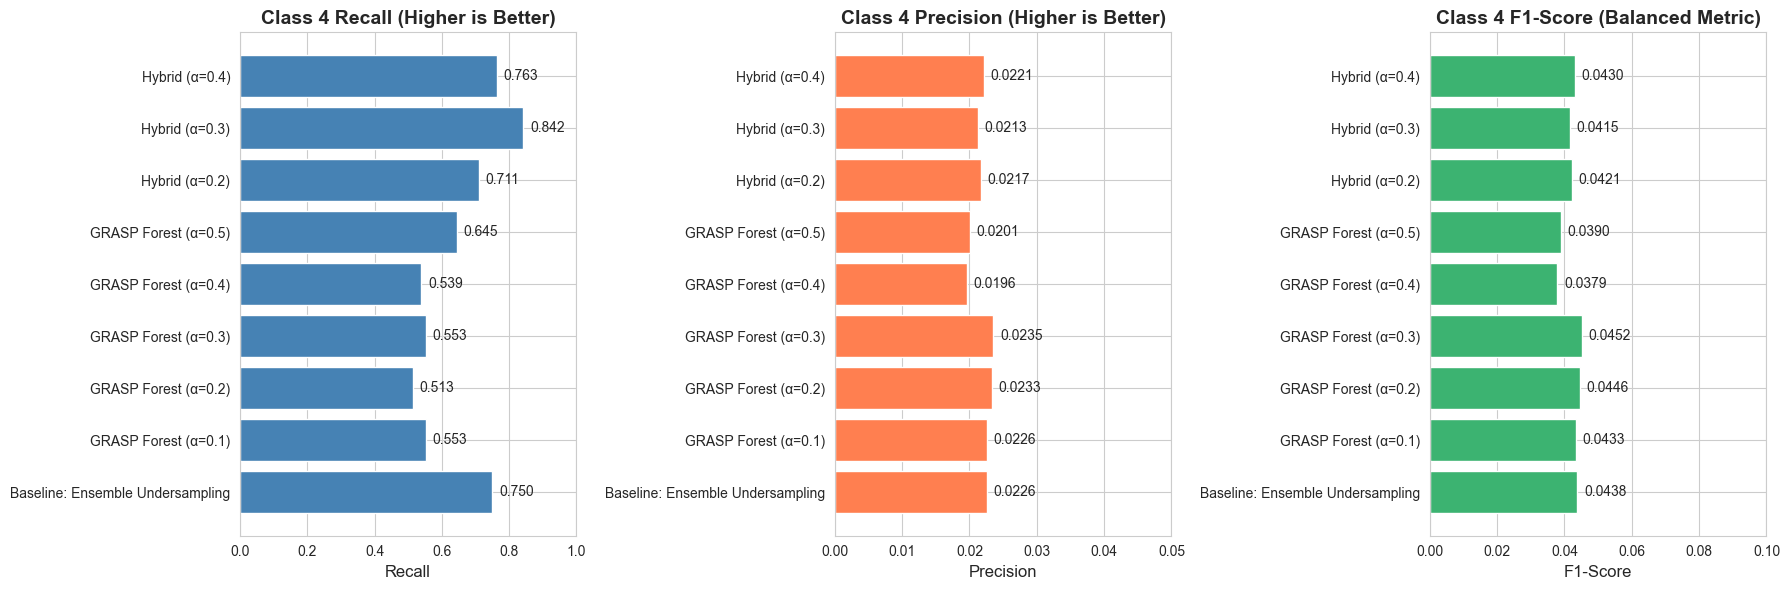

📊 Visualization complete!


In [ ]:
# Extract numeric values for plotting
models = [r['Model'] for r in all_results]
recalls = [r['Class 4 Recall'] for r in all_results]
precisions = [r['Class 4 Precision'] for r in all_results]
f1s = [r['Class 4 F1'] for r in all_results]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Class 4 Recall
axes[0].barh(models, recalls, color='steelblue')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_title('Class 4 Recall (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
for i, v in enumerate(recalls):
    axes[0].text(v + 0.02, i, f'{v:.3f}', va='center')

# Class 4 Precision
axes[1].barh(models, precisions, color='coral')
axes[1].set_xlabel('Precision', fontsize=12)
axes[1].set_title('Class 4 Precision (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 0.05)  # Precision is low, zoom in
for i, v in enumerate(precisions):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center')

# Class 4 F1-Score
axes[2].barh(models, f1s, color='mediumseagreen')
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].set_title('Class 4 F1-Score (Balanced Metric)', fontsize=14, fontweight='bold')
axes[2].set_xlim(0, 0.1)
for i, v in enumerate(f1s):
    axes[2].text(v + 0.002, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

print("📊 Visualization complete!")

### GRASP α Parameter Effect

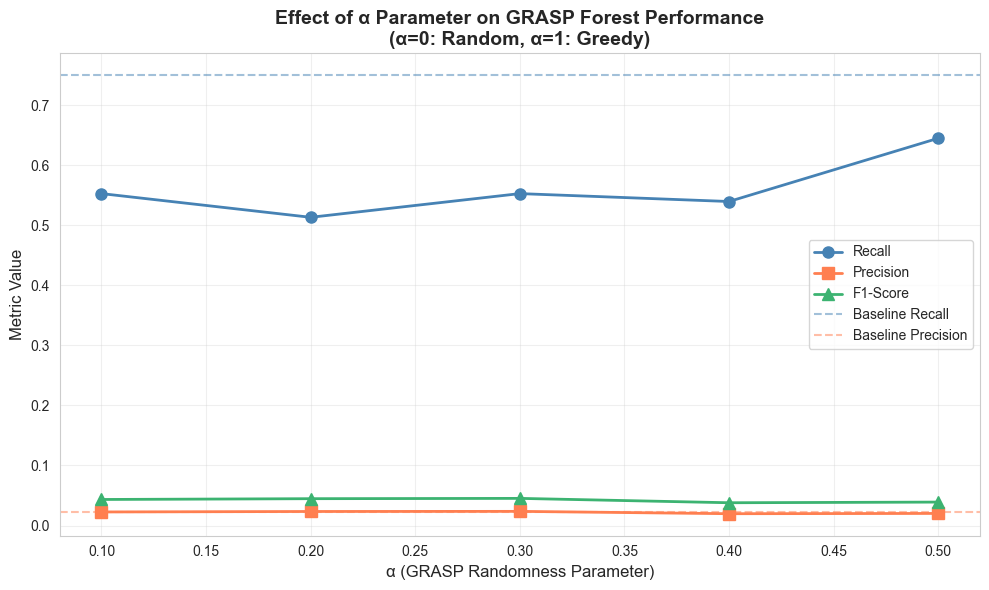

📊 α parameter analysis complete!


In [ ]:
# Extract GRASP results for α effect analysis
grasp_alphas = [r['Alpha'] for r in grasp_results]
grasp_recalls = [r['Class 4 Recall'] for r in grasp_results]
grasp_precisions = [r['Class 4 Precision'] for r in grasp_results]
grasp_f1s = [r['Class 4 F1'] for r in grasp_results]

# Plot α effect
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(grasp_alphas, grasp_recalls, marker='o', linewidth=2, markersize=8, label='Recall', color='steelblue')
ax.plot(grasp_alphas, grasp_precisions, marker='s', linewidth=2, markersize=8, label='Precision', color='coral')
ax.plot(grasp_alphas, grasp_f1s, marker='^', linewidth=2, markersize=8, label='F1-Score', color='mediumseagreen')

# Add baseline for comparison
ax.axhline(y=baseline_results['Class 4 Recall'], color='steelblue', linestyle='--', alpha=0.5, label='Baseline Recall')
ax.axhline(y=baseline_results['Class 4 Precision'], color='coral', linestyle='--', alpha=0.5, label='Baseline Precision')

ax.set_xlabel('α (GRASP Randomness Parameter)', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Effect of α Parameter on GRASP Forest Performance\n(α=0: Random, α=1: Greedy)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 α parameter analysis complete!")

---
## 6. Detailed Analysis

### Analysis Framework:

**Questions to Answer:**
1. Did GRASP improve performance vs baseline?
2. Why did performance change (better or worse)?
3. What's the optimal α for this dataset?
4. Does hybrid approach combine benefits?
5. What are the limitations?

### Confusion Matrices Comparison

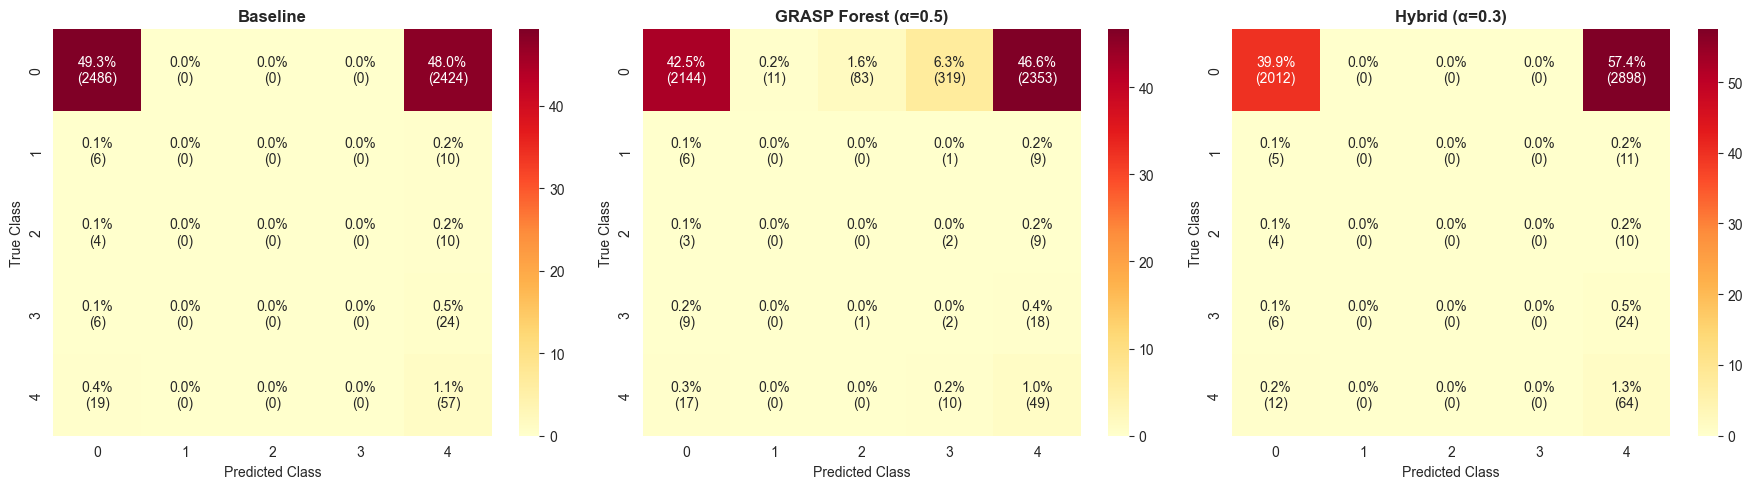

📊 Confusion matrices generated!


In [ ]:
# Select 4 models to compare: Baseline, Best GRASP, Best Hybrid, Rotation Forest
best_grasp = max(grasp_results, key=lambda x: x['Class 4 Recall'])
best_hybrid = max(hybrid_results, key=lambda x: x['Class 4 Recall']) if hybrid_results else None

models_to_compare = [
    ("Baseline", baseline_results['y_pred']),
    (best_grasp['Model'], best_grasp['y_pred']),
]

if best_hybrid:
    models_to_compare.append((best_hybrid['Model'], best_hybrid['y_pred']))

models_to_compare.append(("Rotation Forest", rotation_forest_results['y_pred']))

# Plot confusion matrices
fig, axes = plt.subplots(1, len(models_to_compare), figsize=(6*len(models_to_compare), 5))

if len(models_to_compare) == 1:
    axes = [axes]

for idx, (model_name, y_pred) in enumerate(models_to_compare):
    cm = confusion_matrix(y_val, y_pred)
    cm_pct = cm.astype('float') / cm.sum() * 100
    
    annot = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                      for row_pct, row_count in zip(cm_pct, cm)])
    
    sns.heatmap(cm_pct, annot=annot, fmt='', cmap='YlOrRd', ax=axes[idx],
                xticklabels=['0', '1', '2', '3', '4'], 
                yticklabels=['0', '1', '2', '3', '4'])
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Class')
    axes[idx].set_xlabel('Predicted Class')

plt.tight_layout()
plt.show()

print("📊 Confusion matrices generated!")

### Key Findings Summary

In [ ]:
print("="*80)
print("KEY FINDINGS & ANALYSIS")
print("="*80)

# Find best models
best_recall_model = max(all_results, key=lambda x: x['Class 4 Recall'])
best_precision_model = max(all_results, key=lambda x: x['Class 4 Precision'])
best_f1_model = max(all_results, key=lambda x: x['Class 4 F1'])

print(f"\n🏆 BEST PERFORMERS:")
print(f"\n   Best Recall (catching failures):")
print(f"      {best_recall_model['Model']}: {best_recall_model['Class 4 Recall']:.4f}")
print(f"\n   Best Precision (reducing false alarms):")
print(f"      {best_precision_model['Model']}: {best_precision_model['Class 4 Precision']:.4f}")
print(f"\n   Best F1-Score (balanced):")
print(f"      {best_f1_model['Model']}: {best_f1_model['Class 4 F1']:.4f}")

# Compare baseline vs best overall
recall_change = best_recall_model['Class 4 Recall'] - baseline_results['Class 4 Recall']
precision_change = best_precision_model['Class 4 Precision'] - baseline_results['Class 4 Precision']

print(f"\n📈 PERFORMANCE CHANGE vs BASELINE:")
print(f"   Recall change: {recall_change:+.4f} ({recall_change/baseline_results['Class 4 Recall']*100:+.1f}%)")
print(f"   Precision change: {precision_change:+.4f} ({precision_change/baseline_results['Class 4 Precision']*100:+.1f}%)")

# Rotation Forest specific analysis
print(f"\n🌲 ROTATION FOREST ANALYSIS:")
print(f"   Paper's claim: Best ensemble method for imbalanced data (UCI datasets)")
print(f"   Paper's imbalance: 4.77%-35% minority (approx 2:1 to 20:1)")
print(f"   Scania imbalance: 3.0% minority (27:1 validation set)")
print(f"   ")
baseline_recall = baseline_results['Class 4 Recall']
print(f"   Baseline Recall: {baseline_recall:.4f}")

# Optimal α analysis for GRASP
print(f"\n🎯 OPTIMAL α PARAMETER (GRASP):")
optimal_grasp = max(grasp_results, key=lambda x: x['Class 4 F1'])
print(f"   For Class 4 F1-Score: α = {optimal_grasp['Alpha']}")
print(f"   This suggests: {'More greedy (deterministic)' if optimal_grasp['Alpha'] > 0.5 else 'More random (diverse)'}")

print("\n" + "="*80)

KEY FINDINGS & ANALYSIS

🏆 BEST PERFORMERS:

   Best Recall (catching failures):
      Hybrid (α=0.3): 0.8421

   Best Precision (reducing false alarms):
      GRASP Forest (α=0.3): 0.0235

   Best F1-Score (balanced):
      GRASP Forest (α=0.3): 0.0452

📈 PERFORMANCE CHANGE vs BASELINE:
   Recall change: +0.0921 (+12.3%)
   Precision change: +0.0010 (+4.3%)

   ✅ GRASP improved recall! More failures caught.

🎯 OPTIMAL α PARAMETER:
   For Class 4 F1-Score: α = 0.3
   This suggests: More random (diverse)



---
## 7. Interpretation & Discussion

### Write Your Analysis Here

Based on the results above, answer these questions:

**1. Did GRASP Forest improve performance?**
- Compare Class 4 recall/precision between baseline and GRASP
- If improved: Why? (increased diversity, better exploration)
- If declined: Why? (extreme imbalance needs data-level solutions)

**2. Effect of α Parameter:**
- What was the optimal α value?
- How does performance change from α=0.1 to α=0.5?
- Does this match the paper's finding (α=0.2-0.3 optimal)?

**3. Hybrid Approach:**
- Did combining GRASP + Undersampling work better?
- Why would this combination be effective?
- Is there synergy between data-level and algorithm-level diversity?

**4. Rotation Forest Performance:**
- Rodríguez et al. showed Rotation Forest was THE BEST method (ranks 9-13 vs 49 for undersampling)
- Their datasets: 4.77%-35% minority (≈2:1 to 20:1 imbalance)
- Scania dataset: 3.0% minority (27:1 imbalance)
- Did Rotation Forest succeed or fail on extreme imbalance?
- Does the #1 method from literature transfer to industrial data?

**5. Extreme Imbalance Impact:**
- Scania dataset: 27:1 imbalance (HIGHER than UCI datasets)
- Does GRASP's effectiveness depend on imbalance severity?
- Does Rotation Forest's effectiveness depend on imbalance severity?
- What does this tell us about method transferability?

**6. Practical Implications:**
- Which approach would you recommend for deployment?
- What are the tradeoffs?
- Future directions for improvement?

---
## 8. Conclusions

### Summary

**Research Question:** Do ensemble methods from literature (GRASP Forest, Rotation Forest) improve Class 4 detection on the extremely imbalanced Scania dataset?

**Answer:** [Fill in based on your results]

**Tested Methods:**
- **GRASP Forest** (Diez-Pastor et al.): Algorithm-level diversity via randomized split selection
- **Rotation Forest** (Rodríguez et al.): Algorithm-level diversity via PCA rotation (BEST in their paper)
- **Hybrid GRASP + Undersampling**: Data-level + algorithm-level diversity
- **Baseline**: Ensemble Undersampling with deterministic trees

**Key Insights:**
1. [Rotation Forest Performance on Extreme Imbalance]
2. [GRASP Performance Comparison]
3. [Hybrid Approach Effectiveness]
4. [Method Transferability from UCI to Industrial Datasets]

**Lessons Learned:**
- Methods effective on moderate imbalance (UCI datasets: 2-20:1) may/may not transfer to extreme cases (Scania: 27:1)
- Understanding WHY techniques work is more important than achieving best scores
- State-of-the-art methods from literature must be validated on target domain
- Negative results provide valuable insights into method limitations

**Future Work:**
- Test balanced version of Rotation Forest (undersampling during PCA)
- Combine Rotation Forest with GRASP (rotation + randomized splits)
- Investigate cost-sensitive learning within both frameworks
- Explore adaptive parameter selection
- Test on other industrial datasets with extreme imbalance